In [ ]:
'Ulcer'
'Plaque'
'Dentine caries'
'Leukoplakia'
'Microfracture'

'Gingivitis'
'Attrition/Erosion'
'Fibroma'
'Inflammation'

'Malignant lesion'
'Fluorosis'
'Initial caries'
'Calculus'
'Pigmentation'

Enamel
Attached gingiva
Hard palate
Makeup
Mole
Plastic
Soft palate
Oral mucosa
Blood vessel
prosthetics
Specular reflection
Marginal gingiva
Out of focus area
Root
Stain
Metal
Shadow/Noise
Tongue

In [1]:
# import necessary libraries
import os
import zipfile
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing

In [2]:
# Load image files and append them as array
dataset=[]
datalabel=[]

rootdir= r"C:\Users\ZENBOOK\Documents\Hackathon\MLDADeepLearningWeek2021\OralData"

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print(os.path.join(subdir, file))
        img=cv2.imread(os.path.join(subdir, file))
        resized=cv2.resize(img,(512,512))
        dataset.append(resized)
        datalabel.append(subdir[70:])
    
# Convert dataset array to tensor format
dataset=tf.convert_to_tensor(dataset)
dataset

<tf.Tensor: shape=(309, 512, 512, 3), dtype=int32, numpy=
array([[[[ 81,  87, 124],
         [ 80,  86, 123],
         [ 79,  85, 122],
         ...,
         [ 58,  59, 103],
         [ 58,  59, 103],
         [ 57,  59, 100]],

        [[ 77,  82, 121],
         [ 77,  83, 120],
         [ 77,  82, 121],
         ...,
         [ 60,  60, 106],
         [ 59,  60, 104],
         [ 58,  60, 101]],

        [[ 76,  80, 121],
         [ 75,  80, 119],
         [ 76,  78, 119],
         ...,
         [ 59,  62, 107],
         [ 58,  61, 105],
         [ 58,  61, 105]],

        ...,

        [[ 12,   4,   5],
         [ 13,   5,   6],
         [ 14,   6,   7],
         ...,
         [111,  81,  76],
         [109,  78,  75],
         [108,  77,  74]],

        [[ 14,   6,   7],
         [ 13,   5,   6],
         [ 13,   5,   6],
         ...,
         [110,  80,  75],
         [109,  78,  75],
         [106,  77,  73]],

        [[ 13,   5,   6],
         [ 13,   5,   6],
         [ 14,  

In [3]:
# Create a set of unique class for datalabel
unique_labels=set(datalabel)
unique_keys=set()
for i in range(1, len(unique_labels)+1,1):
    unique_keys.add(i)
unique_dict=dict(zip(unique_labels,unique_keys))

datalabel_numeric=[]
idx=1
for label in datalabel:
    if label in unique_dict:
        datalabel_numeric.append(unique_dict[label])

# Perform onehot encoding to the datalabel     
datalabel_onehot=tf.one_hot(datalabel_numeric,len(unique_labels))
datalabel_onehot

<tf.Tensor: shape=(309, 12), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [4]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

x = dataset
y = datalabel_onehot

# Perform random splitting using StratifiedShuffleSplit method
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
sss.get_n_splits(x,y)
print(sss)

for train_index, test_index in sss.split(x,y):
    x1 = train_index
    x2 = test_index

x_train = tf.gather(x, indices=x1)
x_test = tf.gather(x, indices=x2)
y_train = tf.gather(y, indices=x1)
y_test = tf.gather(y, indices=x2)

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.1,
            train_size=None)


In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (512, 512, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [6]:
i = 0;
for layer in base_model.layers[:15]:
    i += 1
    layer.trainable = False
    
print(i)

15


In [7]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 12 nodes for classification output
x = tf.keras.layers.Dense(len(unique_labels), activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)    

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)

#train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train,
                                     batch_size=10)

validation_datagen = ImageDataGenerator(rescale=1./255)
      
validation_generator = validation_datagen.flow(x_test,y_test,
                                               batch_size=10)

In [9]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator)

Epoch 1/20
28/28 [==============================] - 549s 20s/step - loss: 2.1741 - acc: 0.2482 - val_loss: 1.8074 - val_acc: 0.3871
Epoch 2/20
28/28 [==============================] - 633s 23s/step - loss: 1.6616 - acc: 0.3777 - val_loss: 1.5757 - val_acc: 0.4516
Epoch 3/20
28/28 [==============================] - 627s 22s/step - loss: 1.4570 - acc: 0.4317 - val_loss: 1.4584 - val_acc: 0.4194
Epoch 4/20
28/28 [==============================] - 622s 22s/step - loss: 1.3211 - acc: 0.4820 - val_loss: 1.5870 - val_acc: 0.4516
Epoch 5/20
28/28 [==============================] - 554s 20s/step - loss: 1.0978 - acc: 0.5396 - val_loss: 2.1852 - val_acc: 0.4194
Epoch 6/20
28/28 [==============================] - 560s 20s/step - loss: 1.0507 - acc: 0.5755 - val_loss: 1.5751 - val_acc: 0.4516
Epoch 7/20
28/28 [==============================] - 577s 21s/step - loss: 0.9156 - acc: 0.6151 - val_loss: 1.5408 - val_acc: 0.4194
Epoch 8/20
28/28 [==============================] - 576s 21s/step - loss: 0.

Text(0.5, 1.0, 'Training and validation loss')

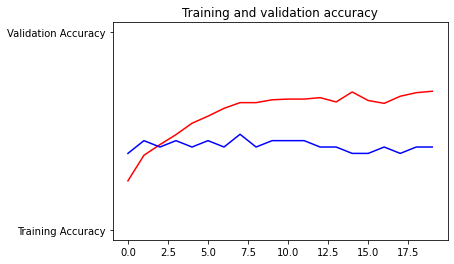

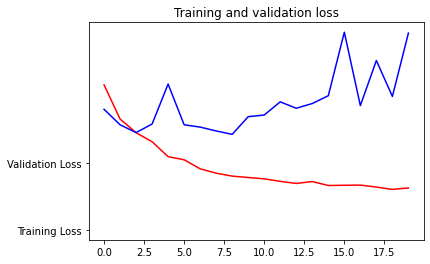

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [12]:
import matplotlib.image  as mpimg

path = 'TrialData/Trial01' 
img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
y_pred = model.predict(x)
y_pred
y_test

NameError: name 'image' is not defined